In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

########################################
# 0. Device (use GPU if available)
########################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

########################################
# 1. Data transforms
########################################
# We will:
# - Resize 32x32 CIFAR -> 224x224 (what ResNet18 expects)
# - Do data augmentation on train (random crop/flip)
# - Normalize using ImageNet mean/std because we're using pretrained weights

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(224, padding=4),  # tiny jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

########################################
# 2. CIFAR-10 Dataset & DataLoaders
########################################
# If you ALREADY have the CIFAR-10 batches locally and don't want to download,
# you can point root to that folder and set download=False.
# If not, just leave download=True and it'll fetch.

train_dataset = torchvision.datasets.CIFAR10(
    root=r"C:\Users\ADMIN\Downloads\cifar-10-python.tar\cifar-10-python\cifar-10-batches-py",
    train=True,
    transform=train_transform,
    download=False,   # set False if you already have data_batch_*
)

test_dataset = torchvision.datasets.CIFAR10(
    root=r"C:\Users\ADMIN\Downloads\cifar-10-python.tar\cifar-10-python\cifar-10-batches-py\test_batches",
    train=False,
    transform=test_transform,
    download=False,
)

BATCH_SIZE = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

print("Train images:", len(train_dataset))
print("Test images :", len(test_dataset))
print("Classes:", train_dataset.classes)

########################################
# 3. Build ResNet-18 model
########################################
# We'll start from pretrained ImageNet weights.
# Then replace the final fully-connected layer (fc) -> 10 classes for CIFAR10.

weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

# Replace last layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

model = model.to(device)

########################################
# 4. Loss function and optimizer
########################################
criterion = nn.CrossEntropyLoss()

# Typical choice: SGD with momentum OR AdamW.
# SGD usually generalizes well for image classification.
optimizer = optim.SGD(
    model.parameters(),
    lr=0.001,         # start small because pretrained
    momentum=0.9,
    weight_decay=5e-4
)

# Optional: learning rate scheduler to reduce LR if val plateaus.
# CIFAR-10 is small, you can skip for first run.
scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=10,     # every 10 epochs
    gamma=0.1         # LR *= 0.1
)

########################################
# 5. Training + evaluation loops
########################################
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        # forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # stats
        running_loss += loss.item() * labels.size(0)
        _, preds = outputs.max(1)
        running_correct += (preds == labels).sum().item()
        running_total += labels.size(0)

    avg_loss = running_loss / running_total
    avg_acc = running_correct / running_total
    return avg_loss, avg_acc


@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * labels.size(0)
        _, preds = outputs.max(1)
        running_correct += (preds == labels).sum().item()
        running_total += labels.size(0)

    avg_loss = running_loss / running_total
    avg_acc = running_correct / running_total
    return avg_loss, avg_acc


########################################
# 6. Full training loop
########################################
EPOCHS = 20
best_acc = 0.0

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    test_loss,  test_acc  = evaluate(model, test_loader, criterion)

    # Step the LR scheduler AFTER each epoch
    scheduler.step()

    dt = time.time() - t0

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"{dt:.1f}s | "
          f"Train Loss {train_loss:.4f} Acc {train_acc*100:.2f}% | "
          f"Test Loss {test_loss:.4f} Acc {test_acc*100:.2f}% | "
          f"LR {optimizer.param_groups[0]['lr']:.5f}")

    # save best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), "resnet18_cifar10_best.pth")
        print("  ✅ Saved new best model (acc = {:.2f}%)".format(best_acc*100))

print("Training done. Best test acc: {:.2f}%".format(best_acc*100))


########################################
# 7. Final test evaluation (load best)
########################################
best_model = resnet18(weights=None)    # fresh init
best_model.fc = nn.Linear(num_ftrs, 10)
best_model.to(device)
best_model.load_state_dict(torch.load("resnet18_cifar10_best.pth", map_location=device))

final_loss, final_acc = evaluate(best_model, test_loader, criterion)
print("Best checkpoint -> Test Loss {:.4f} | Test Acc {:.2f}%".format(final_loss, final_acc*100))


Using device: cuda


100%|███████████████████████████████████████████████████████████████████████████████| 170M/170M [00:50<00:00, 3.38MB/s]


Train images: 50000
Test images : 10000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Epoch 01/20 | 101.9s | Train Loss 0.4696 Acc 85.16% | Test Loss 0.2201 Acc 92.43% | LR 0.00100
  ✅ Saved new best model (acc = 92.43%)
Epoch 02/20 | 101.4s | Train Loss 0.1910 Acc 93.66% | Test Loss 0.1901 Acc 93.48% | LR 0.00100
  ✅ Saved new best model (acc = 93.48%)
Epoch 03/20 | 97.3s | Train Loss 0.1395 Acc 95.33% | Test Loss 0.1571 Acc 94.45% | LR 0.00100
  ✅ Saved new best model (acc = 94.45%)
Epoch 04/20 | 96.4s | Train Loss 0.1095 Acc 96.50% | Test Loss 0.1442 Acc 94.84% | LR 0.00100
  ✅ Saved new best model (acc = 94.84%)
Epoch 05/20 | 97.6s | Train Loss 0.0880 Acc 97.17% | Test Loss 0.1425 Acc 95.05% | LR 0.00100
  ✅ Saved new best model (acc = 95.05%)
Epoch 06/20 | 96.2s | Train Loss 0.0702 Acc 97.73% | Test Loss 0.1411 Acc 95.18% | LR 0.00100
  ✅ Saved new best model (acc = 95.18%)
Epoch 07/20 | 95.0s | Train Loss 0.0585 Acc 98.20% | T

In [2]:
#Testing

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 2. rebuild same model architecture
model = resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 10)

# 3. load trained weights
state_dict = torch.load("resnet18_cifar10_best.pth", map_location="cpu")
model.load_state_dict(state_dict)

# 4. move model to device and eval mode
model = model.to(device)
model.eval()

# 5. evaluate
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

acc = 100.0 * correct / total
print(f"Test Accuracy on CIFAR-10 test set: {acc:.2f}%")

Using device: cuda
Test Accuracy on CIFAR-10 test set: 95.98%


<Figure size 800x800 with 0 Axes>

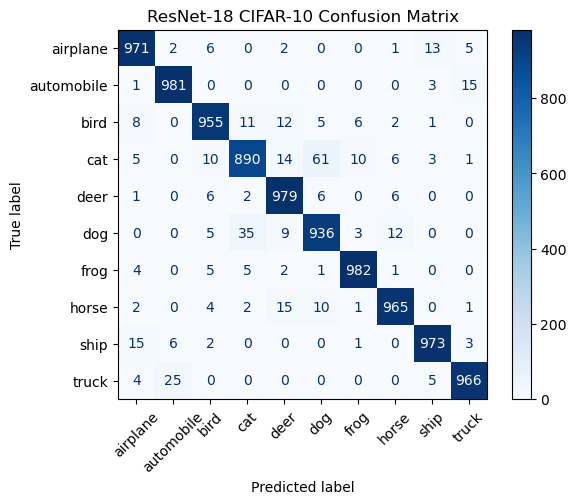


=== ResNet-18 Classification Report ===
              precision    recall  f1-score   support

    airplane       0.96      0.97      0.97      1000
  automobile       0.97      0.98      0.97      1000
        bird       0.96      0.95      0.96      1000
         cat       0.94      0.89      0.92      1000
        deer       0.95      0.98      0.96      1000
         dog       0.92      0.94      0.93      1000
        frog       0.98      0.98      0.98      1000
       horse       0.97      0.96      0.97      1000
        ship       0.97      0.97      0.97      1000
       truck       0.97      0.97      0.97      1000

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



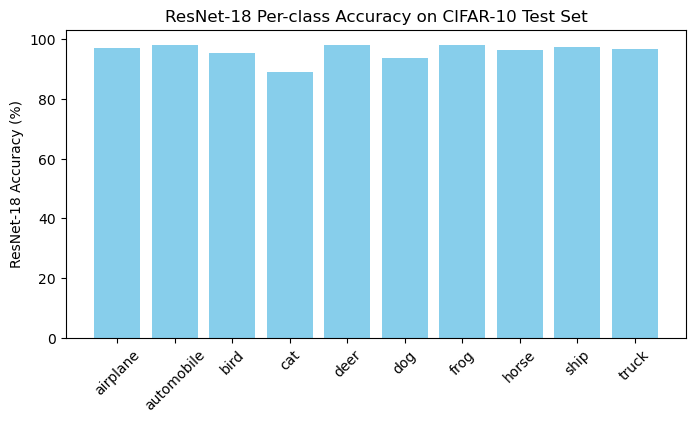

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

# ---- 1. Collect all predictions and labels ----
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ---- 2. Compute confusion matrix ----
cm = confusion_matrix(all_labels, all_preds)
classes = test_dataset.classes  # ['airplane', 'automobile', 'bird', 'cat', ...]

# ---- 3. Plot confusion matrix ----
plt.figure(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap="Blues", xticks_rotation=45, colorbar=True)
plt.title("ResNet-18 CIFAR-10 Confusion Matrix")
plt.show()

# ---- 4. Print detailed classification report ----
print("\n=== ResNet-18 Classification Report ===")
print(classification_report(all_labels, all_preds, target_names=classes))

# ---- 5. (Optional) Per-class accuracy bar plot ----
cm_sum = np.sum(cm, axis=1, keepdims=True)
class_acc = cm.diagonal() / cm_sum.flatten()

plt.figure(figsize=(8,4))
plt.bar(classes, class_acc * 100, color='skyblue')
plt.xticks(rotation=45)
plt.ylabel("ResNet-18 Accuracy (%)")
plt.title("ResNet-18 Per-class Accuracy on CIFAR-10 Test Set")
plt.show()


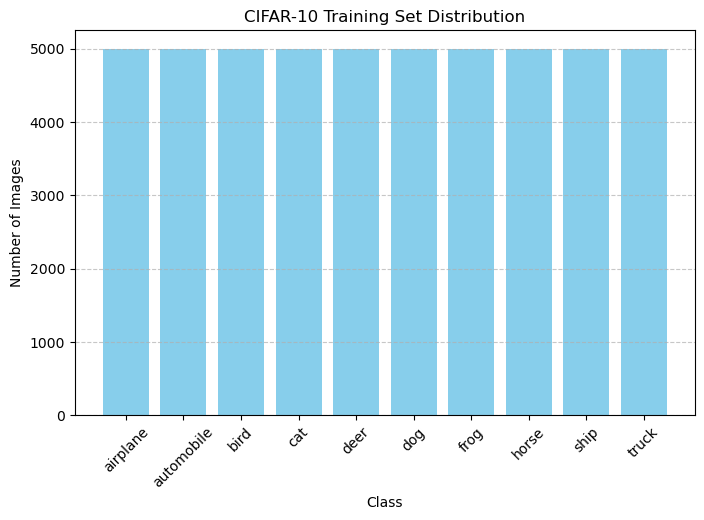

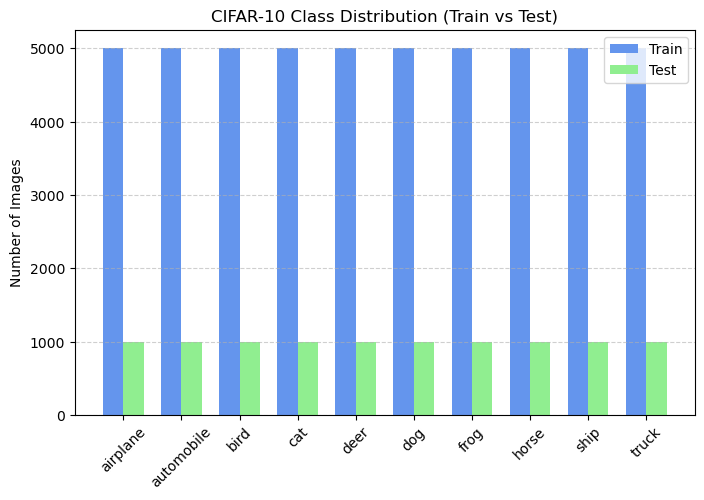

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you've already loaded CIFAR-10
# e.g. train_dataset = torchvision.datasets.CIFAR10(..., train=True, ...)

# Get the labels for all training images
train_labels = np.array(train_dataset.targets)

# Count samples per class
class_counts = np.bincount(train_labels)

# Get class names from the dataset
classes = train_dataset.classes

# Plot
plt.figure(figsize=(8,5))
plt.bar(classes, class_counts, color='skyblue')
plt.title("CIFAR-10 Training Set Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

train_counts = np.bincount(train_dataset.targets)
test_counts  = np.bincount(test_dataset.targets)

x = np.arange(len(classes))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, train_counts, width, label='Train', color='cornflowerblue')
plt.bar(x + width/2, test_counts,  width, label='Test',  color='lightgreen')
plt.xticks(x, classes, rotation=45)
plt.title("CIFAR-10 Class Distribution (Train vs Test)")
plt.ylabel("Number of Images")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()
